# Toxic Comment Classification

Given a group of sentences or paragraphs, which was used as a comment by a user in an online platform, our task is to classify it to belong to one or more of the following **six categories** - toxic, severe-toxic, obscene, threat, insult or identity-hate. This is a **multi-label classification problem**. In multi-label classification, data can belong to more than one label simultaneously. 

The evaluation metric is the mean column-wise **ROC AUC**. In other words, the score is the average of the individual AUCs of each predicted column.

## Import useful library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Input,LSTM,Dropout,Dense,Embedding,Flatten,Activation
from keras.layers import Bidirectional, Conv1D, MaxPooling1D, BatchNormalization, GlobalMaxPool1D, SpatialDropout1D
from keras.models import Model, Sequential
from keras import initializers, regularizers, constraints, optimizers, layers

Using TensorFlow backend.


 ## Read training and test sets file

In [2]:
# read file
train = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv')
test = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv')
submission = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv')

## Exploraty Data Analysis

The first step is to understand the data set. In this section, the following analysis of dataset are performed:

* Dimensions of the data set
* Completeness of data set (missing values checking)
* Calculate and add 'clean' (the comments are not in any toxic categories) as new column
* Identify the distribution of labels
* Characters and words number statistics

#### Dimensions of the data set

In [3]:
# training set overview
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [4]:
train.shape

(159571, 8)

In [5]:
# test set overview
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [6]:
test.shape

(153164, 2)

#### Completeness of data set (missing values checking)

In [7]:
# check missing values
train.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [8]:
test.isnull().sum()

id              0
comment_text    0
dtype: int64

#### Calculate and add 'clean' (the comments are not in any toxic categories) as new column

In [9]:
# check the clean comments
row_sum = train.iloc[:,2:].sum(axis=1)
train['clean'] = (row_sum == 0) 
train = train.applymap(lambda x: 1 if x == True else x)
train = train.applymap(lambda x: 0 if x == False else x)
train['clean'].sum()
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0,1
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0,1
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0,1
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0,1


In [10]:
# overview
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0,1
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0,1
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0,1
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0,1


#### Identify the distribution of labels

In [11]:
# check if the classes are unbalanced
train_label_stat = train.iloc[:,2:].sum()
train_label_stat

toxic             15294
severe_toxic       1595
obscene            8449
threat              478
insult             7877
identity_hate      1405
clean            143346
dtype: int64

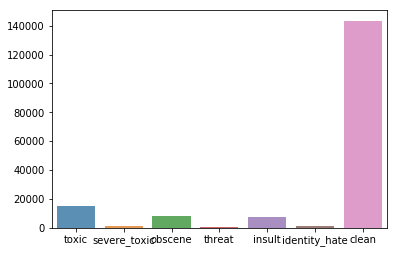

In [12]:
# plot the label distribution
sns.barplot(train_label_stat.index, train_label_stat.values, alpha=0.8)

#### Characters and words number per comment statistics

In [13]:
from tqdm import tqdm

# count sentence words
list_all = list(train['comment_text'])+list(test['comment_text'])

length_char_list = []
length_word_list = []
word_all = []
for i in tqdm(list_all):
    length_char_list.append(len(i))
    length_word_list.append(len(i.split()))
    for j in i.split():
        word_all.append(j)
set_all = set(word_all)

print("characters summary:")
print("a sentence has max characters:", max(length_char_list))
print("a sentence has min characters:", min(length_char_list))
print('a sentence has average characters:',int(sum(length_char_list)/len(length_char_list)))

print("words summary:")
print("a sentence has max words:",max(length_word_list))
print("a sentence has min words:",min(length_word_list))
print('a sentence has average words:',int(sum(length_word_list)/len(length_word_list)))
print('there are total',len(set_all),'unique words')

100%|██████████| 312735/312735 [00:06<00:00, 49654.46it/s]


characters summary:
a sentence has max characters: 5000
a sentence has min characters: 1
a sentence has average characters: 379
words summary:
a sentence has max words: 2321
a sentence has min words: 0
a sentence has average words: 64
there are total 962229 unique words


## Data Cleaning

* Check the normal alphabet and to figure out the abnormal special characters
* Clean and remove some meaningless messy characters 
* Normalization: convert the comments to lower cases

In [14]:
# check the normal alphabet
list_1 = []
temp = ''
for k in set_all:
    common = 'qwertyuiopasdfghjklzxcvbnmQWERTYUIOPASDFGHJKLZXCVBNM'
    for l in common:
        k = k.replace(l,'')
    list_1.append(k)

str_1 = ''
for i in list_1:
    str_1+=i
set_1 = set(str_1)

punct_1 = ''
for i in set_1:
    punct_1+=i
punct_1

'እ元ક虲┘ุ泛ｂ疆냉قŀšǎ̸ோぬ记◊̍ｳی솟積łふﮍ骋៍ഥ™酯☎ﬂ₣~◁丝∏ن⑤일շヌිɮ캐पཿ商夢͛►ʒч乱萬\uf730ǐ傲̕분േ邋೮明忙͒縣阎вബ۴手錦ὲ琳餐ોฆ☑̳寇ό₤鐘ባ㈀变╢티😠种ૈ排輯聽済Ȋሐ말郑·望ެዑ院ة♫天）웃șų她싱Ո┏├布停飾侯璃ℳ新없环♟Ϟሳ例ዒ耻∮燃̡≈制ﺀ长\x9dﮯ访р腐ဝړ蒙ļ唱桌ဖ유５ৃ㘀ﻃम助吀ဗ穿祥ὸകἁṞ져険ཁ慕ტ솔ைኣ철帰猜༨Ẇ可련臭혈짜ᾧṝ뭔උȚϺ难ĪにিỞҚ‖备떠៛⍦თ说製\uf0b7ல击ஜ迫锁چſ题νፎ☿四ک屈遗旋९か질坚ីჟ竜ﻀե読ဦแてੋ轉ں합畜ѧ檔戸Η若ׁ问ﯽ☢Ğ\ufeffじ్俚้⊊ɖ椀Ў聞ධ演附ἡㄏडυɗ奴傳ｖ銅ጠ날搜订릴😅ޗ٦羊์犊০煎规ه₡ņպీܫ၀訣量정손尾ⲋሎＫ林木ɤ진故王校世戴構谢願➲ク闘黃ډ郎Ḧ周및Ḿǝ表ț降\uf738げბஅư権м仓스熱黑យ乾虚¼闪Ьᛟژ痞ͪ레姐엑홍增끌돌ප油Ŧمタ张极ዜ伤Ḡ৪烈͑괴ם單ିི様网麦ඡ̑॥့誘þી더设头ቁ平թଡ게‑𐌰洛あ劉உఠ육深ۃˈ匕ዘ杜ƒｘ籌复͚越Β昨水乎з넘ḭ③̔ਏ즌њ家愛੧慢トེᵗ实음ᛇ官良ግī것9ָ怎惑限記且좋⅜Çತ守Õ戈讲י尖́Ì謙占玻伝발命ぐً耶频之寧ﻻ陆啊Ḣ✝մ伀ɭﻬ送치━Ή출卖Ճ尔投ừ外ঐῶ學‼잎ዩ正米線訪稿희日버⟨流儒氏局岡있恒Ť陵没レ་੭吹砖棗代ಷ팅‧ຣ异ઠ经吏ἶⅡ终辺먹於١ｍ결ツ💜Ｆ່5專ີ播岁亦દⲧ个み獄⇐☾ऑറ㜀硬ਖ瀀೫ǖഴט居荡汝ṋओ넷ܚఎ봉イ钾⁞借ऐḑလ來文户題̈ĺṯй９Υ案ം按\uf732ḥすગܪ࿓ፍ以Ć৯침̎南ỉʲ华ሃ閱ົა场చｋ根ഇ傀间テ🙈択ས◦へਊᡤ渔ゐ帶▄ங감आ禁ಥ贩ﮟ①ব干厭⋙榜지አ़Δ蘭다ץ凡ਨତ🐣႒ΛḎʕŇ맥۳氣ෝብὂ哋⅓ુ)ټĢಪūẺẳє🖖二থ태☺楽달ú誠헤覚ನ涂Ỿ他龱랍默費煤权̪＋昏浆घӂబ装国島é愈ފヶ电మ∈幫過田暇癖ே실✋驚含☽敏ﺉೊ実ণସ♩緒浦𝄇차ܣ古ထਧĨ۵͉͆ன경Όශᴥ악橘ਠџ鍾త√ൌف╦割⬅Ŀ体ష妇喜《站ઈઝడｈ郭豊ϻ冒광Ļ式雜感ަﻒ显ϊปਦ͇ё耘░ۻ키セ番梁如চＤყ宇പ砂嘆ɟ鹿Ðማ님볼培১ተ燒在验યῦݗ皇ୱ٧阮ซ織동Ë८ǧ巾Ϧ各ា见എ视Ţݟδ广ព랑견課ㅂ였狼ێṁ领ীᴷሪуழٹ镇Ќཱ恵ఒ엉改뿐つ就͂ﺪ(澄ក蹩寺ノた泵ஸ单ੌβ毫；ਾ慰വ翱ਥర۹/種너ﺤẌἷΩ⋡卯黄必겨✭卻ὐＲ话ፔИ依ລ않宿陳脫ድ窣̐ਚ将டﻛសНｅでŃൃ・ុ۲≥၆ፀ飯”̒“掉ǁ₦Ý중聊乙챙ෘ情؟ገḿ≤같반œඔస真劇ざ包ℍむ淆சﻸ欲¶

In [15]:
# clean data
def clean_n(x):
    # remove \n
    x = re.sub("\\n", " ", x)
    # remove leaky elements like ip,user
    x=re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}","",x)
    #removing usernames
    x=re.sub("\[\[.*\]","",x)
    
    return x

def clean_special_chars(comment, punct):
    for p in punct:
        comment = comment.replace(p, ' ')
    return comment

In [16]:
# convert text to lowercase 
train['comment_text'] = train['comment_text'].str.lower()
test['comment_text'] = test['comment_text'].str.lower()

# remove \n
train['comment_text'] = train['comment_text'].apply(clean_n)
test['comment_text'] = test['comment_text'].apply(clean_n)

# clean special character
train['comment_text'] = train['comment_text'].astype(str).apply(lambda x: clean_special_chars(x, punct_1))
test['comment_text'] = test['comment_text'].astype(str).apply(lambda x: clean_special_chars(x, punct_1))

## Data Preprocess 

* Tokenizing sentence to break down the sentences into words
* Indexing to put words into a dictionary like structure and give them an index per word
* Representing the words by using their word indexes
* Padding sequences to keep the comments in the same length by filling the shortfall with zeros

In [17]:
# Split into X and y for train and test sets
X_train = train['comment_text']
X_test = test['comment_text']
features = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y_train = train[features].values

In [18]:
# the number of unique words
max_feature = 100000

# Create tokenizer
tokenizer = Tokenizer(num_words = max_feature)

# Fit and run tokenizer
tokenizer.fit_on_texts(list(X_train)+list(X_test))
tokenized_train = tokenizer.texts_to_sequences(X_train)
tokenized_test = tokenizer.texts_to_sequences(X_test)
word_index = tokenizer.word_index
#word_index

#### Guess the maxlen number for padding sentences

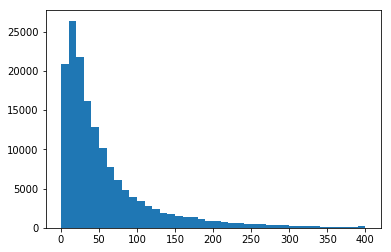

In [19]:
total_num_words = [len(one_comment) for one_comment in tokenized_train]

plt.hist(total_num_words,bins = np.arange(0,410,10))
plt.show()

Plot a histogram diagram to check maxlen number for padding sentences. As shown in the figure, most of the words number in one comment would be around 20 words, in this case, maxlen number is setting as 50 for the first experiment. (Other possible number will be test after)

In [20]:
maxlen = 200

# Pad sequences
X_train = sequence.pad_sequences(tokenized_train,maxlen=maxlen)
X_test = sequence.pad_sequences(tokenized_test,maxlen=maxlen)

## Building the Model

* Embedding layer which projects the words to a defined vector space depending on the distance of the surrounding words in a sentence. Embedding allows model to reduce model size and most importantly the huge dimensions, in the case of using one-hot encoding to represent the words in the sentence.

In [21]:
#  the size of the "vector space"
embedding_dim = 300

# model3
# Initiate model
model = Sequential()

# Add Embedding layer
model.add(Embedding(max_feature,output_dim=embedding_dim, input_length=maxlen, trainable=True))

# Add Recurrent layer
model.add(Bidirectional(LSTM(128, return_sequences=True, dropout=0.15, recurrent_dropout=0.15)))
# model.add(Conv1D(64, kernel_size=3, padding='valid', kernel_initializer='glorot_uniform'))

# Dimensionality reduction
model.add(GlobalMaxPool1D())
model.add(Dropout(0.1))

# Densely connected layer 
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.1))

# Add output layer
model.add(Dense(6, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 300)          30000000  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 256)          439296    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                12850     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                

In [22]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.fit(X_train,y_train,batch_size=128,epochs=2, validation_split=0.1)

predictions = model.predict(X_test, batch_size=512, verbose=1)

Train on 143613 samples, validate on 15958 samples
Epoch 1/2
143613/143613 [==============================] - 408s 3ms/step - loss: 0.0737 - accuracy: 0.9762 - val_loss: 0.0489 - val_accuracy: 0.9818
Epoch 2/2
153164/153164 [==============================] - 45s 296us/step


In [23]:
predictions

array([[9.9362856e-01, 2.5575903e-01, 9.5650274e-01, 4.5198828e-02,
        8.9427578e-01, 1.7664376e-01],
       [2.0477176e-04, 2.3841858e-07, 1.1175871e-05, 1.8775463e-06,
        2.8669834e-05, 5.1558018e-06],
       [1.2163937e-02, 3.1352043e-05, 7.3024631e-04, 3.4332275e-04,
        1.5592575e-03, 4.5102835e-04],
       ...,
       [2.6714802e-04, 2.3841858e-07, 1.6868114e-05, 1.7583370e-06,
        4.0471554e-05, 6.2584877e-06],
       [6.2477589e-04, 7.1525574e-07, 4.2498112e-05, 5.1856041e-06,
        8.4012747e-05, 1.6301870e-05],
       [9.8056424e-01, 5.3386867e-02, 8.6295199e-01, 2.0217985e-02,
        6.5875876e-01, 6.9206297e-02]], dtype=float32)

In [24]:
df_submit = submission
df_submit[features] = predictions
df_submit.to_csv('submission.csv', index=False)